In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import cv2
import sys
import os
if "../models/" not in sys.path:
    sys.path.append("../models/")


# images used for sanity check
# You most likely don't have this dataset and don't have to do it.
# In that case start executing from the cell where ResNetModified is created.
imagnet_dir = "/Users/mitrylitvin/School/SEMESTER_5/VIR/hw03/hw03/vir/hw3/train"

# actual medical images
train_set_path = "/Users/mitrylitvin/School/Erasmus/PROJECT_S8/nerf-optique/data/dataset/train_test_full_roi/train_data/images/"
test_set_path = "/Users/mitrylitvin/School/Erasmus/PROJECT_S8/nerf-optique/data/dataset/train_test_full_roi/test_data/images/"


from resnet import ResNetModified, ResNetForSanityCheck, Bottleneck

In [2]:
# create a resnet for sanity check and a ready-made one from torchvision models

block = Bottleneck
layers = [3, 4, 23, 3]
model = ResNetForSanityCheck(block, layers)
model_pretrained = tv.models.resnet101(weights=tv.models.ResNet101_Weights.IMAGENET1K_V1)

In [4]:
# normalize data as needed for resnet in pytorch documentation.
# Create dataset and dataloader for a training pipeline.
# it's really unnecessarry since in this notebook 
# I tested only on one image, but it will come handy
# for training / computing loss on the whole dataset.

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
 
data_transform = tfms.Compose([tfms.Resize((256, 256)), tfms.ToTensor(),  tfms.Normalize(mean, std)])
 
imagenet_dataset = tv.datasets.ImageFolder(imagnet_dir, transform=data_transform)

BATCH_SIZE = 1
imagenet_dataloader = DataLoader(dataset=imagenet_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [6]:
# just vizualize the data
# sometimes crashes my kernel ;)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


img1 = (imagenet_dataset[0][0])
# imshow(img1)

img1 = torch.unsqueeze(img1, 0)
img1.size()


torch.Size([1, 3, 256, 256])

In [7]:
# check mine and pytorch model's predictions

print(model_pretrained(img1).argmax())
print(model(img1).argmax())
print(len(list(model.modules())))
print(len(list(model_pretrained.modules())))

tensor(463)
tensor(889)
287
287


In [8]:
# assign pretrained weigths to my model layers

for layer_mod, layer_mod_trained in zip(model.modules(), model_pretrained.modules()):
    if isinstance(layer_mod, nn.Conv2d):
        layer_mod.weight = layer_mod_trained.weight
    
    if isinstance(layer_mod, nn.Linear):
        layer_mod.weight = layer_mod_trained.weight
        layer_mod.bias = layer_mod_trained.bias

    if isinstance(layer_mod, nn.BatchNorm2d):
        layer_mod.weight = layer_mod_trained.weight
        layer_mod.bias = layer_mod_trained.bias


In [9]:
print(model_pretrained(img1).argmax())
print(model(img1).argmax())

tensor(463)
tensor(463)


In [10]:
# use first layer of resnet101 to encode images for segmentation
block = Bottleneck
layers = [3, 4, 23, 3]

resnet_modified = ResNetModified(block, layers)

In [11]:
for layer_mod, layer_mod_trained in zip(resnet_modified.modules(), model_pretrained.modules()):
    if isinstance(layer_mod, nn.Conv2d):
        layer_mod.weight = layer_mod_trained.weight
        layer_mod.requires_grad_(False)
    
    if isinstance(layer_mod, nn.Linear):
        layer_mod.weight = layer_mod_trained.weight
        layer_mod.bias = layer_mod_trained.bias
        layer_mod.requires_grad_(False)

    if isinstance(layer_mod, nn.BatchNorm2d):
        layer_mod.weight = layer_mod_trained.weight
        layer_mod.bias = layer_mod_trained.bias
        layer_mod.requires_grad_(False)

In [14]:
# sanity check

x = resnet_modified(img1)
x = model.forward_after_modified(x)
print(x.argmax())

tensor(463)


Sanity check included creating an object of resnet101 implemented by me, assigning weights of original pytorch resnet101 to the layers of my implementation and comparing their results.\
\
*Check 1: weigts of pytorch implementation can be assigned to mine -> it's possible to use pretrained weights;*\
*Check 2: outputs of both networks are the same -> all the needed weights have been assigned correctly*.

### It worked.
Now the modified resnet101 can be used as an encoder for semantic segmenation.

In [15]:
x = resnet_modified(img1)
x.shape

torch.Size([1, 256, 64, 64])

In [217]:
# modes of upsampling : 'nearest', 'linear', 'bilinear', 'bicubic'
# one more option: nn.ConvTranspose2d, but it requires training

upsmpl = nn.Upsample(scale_factor=4, mode = 'bicubic')
x = upsmpl(resnet_modified(img1))
print("Upsample:       ", x.shape, img1.shape)


in_channels = 256
out_channels = in_channels

trans_conv = nn.ConvTranspose2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=4,
                                stride=4, 
                                padding=0)

x = trans_conv(resnet_modified(img1))

print("ConvTranspose2d:", x.shape, img1.shape)

Upsample:        torch.Size([1, 256, 256, 256]) torch.Size([1, 3, 256, 256])
ConvTranspose2d: torch.Size([1, 256, 256, 256]) torch.Size([1, 3, 256, 256])


In [218]:
class CustomImageDataset(Dataset):
  def __init__(self, img_folder, transform):
    self.transform=transform
    self.img_folder=img_folder
    self.image_names = list(os.listdir(img_folder))
     
  def __len__(self):
    return len(self.image_names)
 
  def __getitem__(self, index):
     
    image=cv2.imread(self.img_folder + self.image_names[index])
    # image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
 
    image=self.transform(image).unsqueeze(0)
    # targets=self.labels[index]
     
    # sample = {'image': image,'labels':targets}
    sample = {'image': image}
 
    return sample

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transform = tfms.Compose([tfms.ToTensor(),  tfms.Normalize(mean, std)])
 
train_dataset = CustomImageDataset(train_set_path, transform=data_transform)

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [219]:
arr = torch.tensor([[1, 2, 3],
                    [4, 5, 6]])

arr_normed = arr / torch.sqrt((arr**2).sum(axis=1).unsqueeze(1))

print((arr_normed**2).sum(axis=1))

tensor([1.0000, 1.0000])


In [220]:
img_medic = train_dataset[0]['image']
img_medic.requires_grad_(False)
img_medic.shape
x = resnet_modified(img_medic)
x = upsmpl(x)
# trans_conv.requires_grad_(False)
# x = trans_conv(x)
x_normed = x / torch.sqrt((x**2).sum(axis=1).unsqueeze(1))
print(x.shape, img_medic.shape)
print(((x_normed**2).sum(axis=1) - 1).sum())
print((x_normed**2).sum(axis=1))

torch.Size([1, 256, 496, 476]) torch.Size([1, 3, 496, 474])
tensor(-0.0011)
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])


In [221]:
x = x_normed.squeeze(0)

In [222]:
x_reshaped = torch.reshape(x, (x.shape[0], x.shape[1] * x.shape[2]))
x_reshaped.shape

torch.Size([256, 236096])

In [223]:
((x_reshaped**2).sum(axis=0))

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [224]:
from sklearn.cluster import KMeans

In [225]:
n_clusters = 2
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [226]:
kmeans.fit(x_reshaped.T)

KMeans(init='random', n_clusters=2, n_init=10, random_state=42)

In [227]:
(kmeans.labels_).shape

(236096,)

In [228]:
x_final = np.reshape(kmeans.labels_, ((1, x.shape[1], x.shape[2])))

In [229]:
x_final.shape

(1, 496, 476)

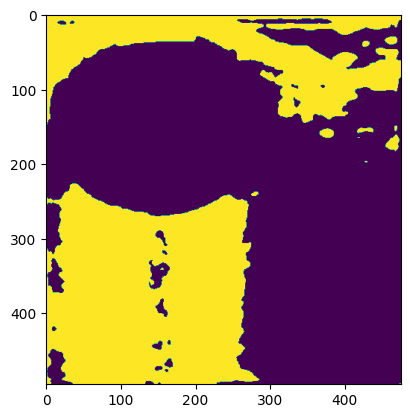

In [230]:
plt.imshow(x_final.transpose(1, 2, 0))

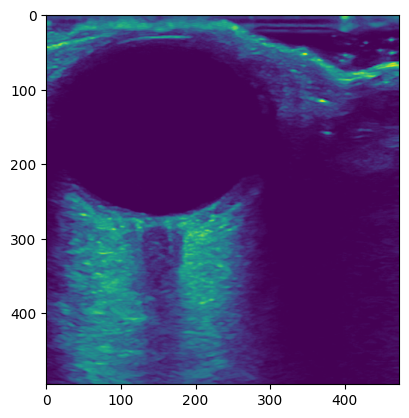

In [71]:
plt.imshow(img_medic.squeeze(0).numpy().transpose(1, 2, 0)[..., :3] @ [0.33, 0.33, 0.33])

In [231]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)

In [232]:
pca_fit = pca.fit_transform(x_reshaped.T)

In [233]:
pca_fit.shape

(236096, 30)

In [234]:
kmeans.fit(pca_fit)

KMeans(init='random', n_clusters=2, n_init=10, random_state=42)

In [235]:
x_after_pca = np.reshape(kmeans.labels_, ((1, x.shape[1], x.shape[2])))

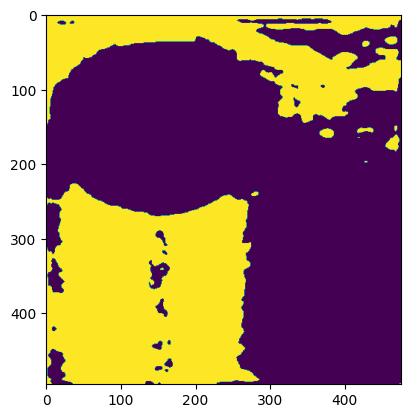

In [236]:
plt.imshow(x_after_pca.transpose(1, 2, 0))